Hui-Kang Tong admin, [2 Apr 2018 at 19:31:29]:
ok we can now automatically generate midi files, convert midi files to wave files (with hk’s mac)

However to create training data, we need many data (audio samples) with the same target/label (note). So these are a few ways to vary it:
- note velocity
- note volume
- noise
- onset timing (one slightly later than the other)
- soundfont (which mean instrument)

So I will write a notebook which
- leave a space for the function to create .mid file with note
- use fluidsynth to convert this .mid file .wav
- call this .mid file, identify onset with our onset function, and splice 4096 entries from it
- leave a space for the training function
- delete the .mid file and .wav file
- repeat

What needs to be considered/written
what kind of model are we using, how do we train such a model, what sort of instructions does the .mid files have

In [1]:
from midiutil.MidiFile import MIDIFile
from itertools import combinations
import os
import subprocess
from time import sleep
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import sounddevice as sd
from itertools import combinations

scales = range(5,6)  # C4 (middle C) to C5
no_of_notes = range(2, 5)  # 2 notes to 4 notes

channel = 0
time = 0.5
duration = 2
tempo = 100
volume = 100

In [2]:
def rcoeff_(snippet):
    return np.corrcoef(snippet, np.arange(len(snippet)))[0, 1]

rcoeff = np.vectorize(rcoeff_, signature='(n)->()')

def divide_chunks(signal, intervals, snippet_size):
# yield successive n-sized chunks from l.
    for i in range(0, len(signal) - snippet_size, intervals):
        # looping till the end of the array
        yield signal[i:i + snippet_size]
        
def max_to_one(arr):
    '''scale the maximum of an array to one'''
    return np.divide(arr, np.max(np.absolute(arr)))

def detect_onset_given_entire_signal(signal):
#     print(len(signal))
    signal_cs = np.cumsum(np.absolute(signal))
    signal_cs = np.add(signal_cs, np.random.randn(len(signal_cs)))
#     print(len(signal_cs))
    signal_chunk_sum = signal_cs[4096:] - signal_cs[:-4096]
    snippets = np.array(list(divide_chunks(signal_chunk_sum, 32, 4096)))
    signal_rcoeff = rcoeff(snippets)
    plt.plot(np.arange(4096, len(signal)), max_to_one(signal_chunk_sum))
    plt.plot(np.arange(4096*2, len(signal), 32), signal_rcoeff)
#     print("loc")
#     print(signal_rcoeff)
#     print(np.where(signal_rcoeff>0.8)[0][0])
    location = np.where(signal_rcoeff>0.8)[0][0]
    start_pt, end_pt = location*32+8192, location*32+8192+4096
    plt.axvline(x=start_pt)
    plt.axvline(x=end_pt)
    plt.show()
    return signal[start_pt:end_pt]

In [3]:
# def divide_chunks(l, n):
# # yield successive n-sized chunks from l.
#     for i in range(0, len(l), n):
#         # looping till length l
#         yield l[i:i + n]

# def detect_onset_given_entire_signal(signal):
#     # input: a one-dimensional array
#     # output: the snippet of 4096 that is to be used for note detection
#     chunk_array = list(divide_chunks(signal, 2048))

#     detected = -1
#     position = 0
#     for i in range(len(chunk_array)-5):
#         detected = detect_onset(np.concatenate(chunk_array[i:i+4]))
#         print(detected)
#         if detected != -1:
#             position = i
#             break
        
#     offset = 4100
#     signal_to_ayse = signal[detected+offset+2048*position:detected+4096+offset+2048*position]
#     return signal_to_ayse

    
# def detect_onset(signal):
#     '''
#     input
#     '''
#     '''
#     Remember how this was originally conceived.
#     HK wanted to simplify calculations.
#     '''
#     # probably in the future we detect onset at every 32 points
# #     '''
# #     input: signal divided into piece of 32
# #     function: find the onset
# #     output: the location of the onset
    
# #     comments:
# #     I have changed this from the bad design of taking 2048 as a chunk, and dividing this into pieces.
# #     (Why did I did it that way because the sample code did it that way,
# #     and I thought it waiting for result will take quite a lot of time and chunks will be lost.)
# #     Now we will read and check for onset at the same time.
# #     Now one "chunk" will be same size as one "piece".
# #     The length that is sent for note detection is larger, however.
# #     '''
    

#     chunksize = 2048
#     tempo_res = 32
    
#     # default value of onset, overwritten if onset is detected
#     onset = -1
#     assert len(signal) == 4*chunksize

#     # to detect difference
#     difference = np.cumsum(np.add(np.absolute(signal[chunksize:-chunksize]), -np.absolute(signal[:-2 * chunksize])))

#     # white noise is added the the difference
#     # this is to desensitise detection of low amplitdue onset sounds
#     noise = 10 * np.array(np.random.randn(len(difference)))
#     difference = np.add(difference, noise)

#     # calculation of r-coefficient
#     # -1 is negatively correlated
#     # +1 is positively correlated
#     # onset is when r-coefficient cuts above 0.8
#     roceff = np.full(tempo_res, 0.)
#     tempo_num = int(chunksize / tempo_res)
#     for i in range(tempo_res):
#         roceff[i] = np.corrcoef(difference[i * tempo_num:(i * tempo_num + chunksize)],
#                                 np.arange(chunksize))[0, 1]
#         # special case when i = 0, because we do not have the previous value
#         #         if i == 0 and roceff[0] > 0.8:
#         #             onset = i
#         # print(roceff[i])
#         if roceff[0] < 0.7 and roceff[i] > 0.7 and np.max(roceff[:i]) < 0.7:
#             onset = i

#     #     if onset != -1:
#     #         # clear output from jupyter
#     #         clear_output(wait=True)
#     #         plt.figure(figsize=(16,2))
#     #         plt.plot(np.arange(2048*1,2048*3),np.array(difference)/np.max(difference))
#     #         plt.plot(np.arange(2048*2,2048*3,64),roceff)
#     #         plt.plot(signal)
#     #         plt.axvline(x=2048*1+64*onset, color="r")
#     #         plt.axvline(x=2048*3+64*onset, color="r")
#     #         plt.show()
#     return onset  # none, or a value

In [4]:
def cqt_function(signal_to_ayse, plotting=False):
    '''
    Compute the cqt response over a set of notes.

    Parameters
    ----------
    signal_to_ayse : input array, real
                     4096 entries long

    Output
    ----------
    MIDI numbers
    60 is middle C, which is C4
    
    Todo
    ----
    We should not be generating the kernels every time.
    Actually we could simply multiply with the FFT of the signal.
    So:
    Make it customisable to a random starting note.
    Outsource the precomputation to a function instead - do something like load kernels.
    Do both of these at the same time.
    (but anyway we just want an accurate demo, computation time doesn't seem to be a problem here)
    '''

    length = len(signal_to_ayse)
#     print(length)

    # fast fourier transform
    freq_domain = np.fft.fft(signal_to_ayse)
    
    plt.figure(figsize=(12,2))
    plt.plot(np.absolute(freq_domain[:400]))
    plt.title("Spectrum of signal analysed")
    plt.show()

    # defining the 36 notes bins
    bins = 40
    freq_ref_notes = [261.625565 * (2. ** (n / 36. - 5. / 72.)) for n in range(bins)]

    # defining the time kernel
    # different note have different "kernels"
    bell_curves = []
    for note in range(len(freq_ref_notes)):
        # I don't think this is defined properly?
        bell_curve = np.exp(-((np.arange(-1., 1., 2. / length)) * (2. ** (note / 36.))) ** 2.)
        bell_curves.append(bell_curve)

    # multiplying the waveform with the window
    kernels = []
    for note in range(bins):
        # generate cosine/sine wave
        wave = np.exp((np.arange(length) - length / 2.) * -1.j * 2. * np.pi * freq_ref_notes[note] / 44100.)
        # multiplying a window over it
        kernels.append(np.multiply(wave, bell_curves[note]))

    # taking fourier transform for the frequency kernel
    fft_kernels = []
    for note in range(bins):
        fft_kernels.append(np.fft.fft(kernels[note]))
    # all of the above should be run only once
    # but the maximum complexity is only the FFT, it is still not a problem
    # the focus is an MVP anyway
    # we prioritse accuracy here though
    # creating arrays to populate for each one-third-semitone
    cqt_resp_specs = []
    cqt_resp = []

    # populating the arrays
    for note in range(bins):
        cqt_resp_spec = []
        for entry in range(length):
            cqt_resp_spec.append(fft_kernels[note][entry] * freq_domain[entry])
        cqt_resp_specs.append(cqt_resp_spec)
        cqt_resp.append(sum([abs(x) for x in cqt_resp_spec]))

    # finding peaks in the cqt response
    notesrum = cqt_resp  # remove redundant variable please

    #     plt.figure(figsize=(16,2))
    #     plt.plot(np.linspace(0, 70*44100/4096, num=70, endpoint=False),
    #              np.absolute(freq_domain[:70])/np.max(np.absolute(freq_domain[:70])))
    #     plt.plot(np.geomspace(261.625565*2**(-3/36), 261.625565*2**(37/36), num=40, endpoint=False),
    #              np.absolute(cqt_resp)/np.max(np.absolute(cqt_resp)))
    #     plt.show()

    notesrum_peak_only = [0.0] * len(notesrum)
    notesrum_sum = sum(notesrum)

    for index in range(bins - 1)[1:]:
        if notesrum[index - 1] < notesrum[index] and notesrum[index + 1] < notesrum[index]:
            notesrum_peak_only[index] = notesrum[index]

        # known_octave = notesrum_peak_only[12:12+36] # don't know what is this for
    known_octave = notesrum_peak_only[2:-2]
    # print(np.round(known_octave,5)/notesrum_sum)

    notesrum_peak_only_sum = sum(notesrum_peak_only)

    for x in range(36):
        # if known_octave[x]/notesrum_sum < 0.1:
        if known_octave[x] / notesrum_peak_only_sum < 0.2:
            known_octave[x] = 0

    known_octave_notes = []
    for notes in range(36 // 3):
        known_octave_notes.append(known_octave[3 * notes]
                                  + known_octave[3 * notes + 1]
                                  + known_octave[3 * notes + 2])

    # notestrum_sum = sum(notesrum)  # alternate demoninator to calc threshold
    # print(np.round(known_octave_notes,5)/notesrum_peak_only_sum)
    # print("check")

    notesrum_peak_only_sum = sum(notesrum_peak_only)

    output = []

    for x in range(12):
        if known_octave_notes[x] / notesrum_peak_only_sum > 0.1:
            output.append(x + 60)

    #     plt.figure(figsize=(16,2))
    #     plt.plot(notesrum_peak_only)
    #     plt.plot(notesrum)
    #     plt.axhline(y=0.1*notesrum_peak_only_sum, color='r', linestyle='-')
    #     plt.show()
    return output

In [5]:
def generate_midi_file(no_,track,com,channel=0):
    # generate and save midifile
    mf = MIDIFile(no_)

    for num in range(no_):
        mf.addNote(track[num], channel, com[num], time, duration, volume)

    code = []
    for num in com:
        code.append(num)
    while len(code) < 4:
        code.append("x")

    filename = "C{}_{}_{}_{}_{}".format(scale-1, code[0], code[1], code[2], code[3])
    print(filename)
    with open("midifile_sch/{}.mid".format(filename), "wb") as outf:
        mf.writeFile(outf)
        
    return filename

In [6]:
def convert_midi_to_signal(filename):
    # generate sound
    subprocess.run("fluidsynth -F soundfile_sch/{}.wav ~/soundfonts/GeneralUser\ GS\ v1.471.sf2 midifile_sch/{}.mid"
                   .format(filename,filename),shell=True)
    sleep(1)
    subprocess.run("rm midifile_sch/{}.mid".format(filename),shell=True)  # remove midifile
    return sf.read("soundfile_sch/{}.wav".format(filename))

In [7]:
def generate_and_train(no_,track,com,channel=0):
    
    
    # generate midi file
    filename = generate_midi_file(no_,track,com,channel)
    
    
    
    # convert midi file to signal
    audio, sr = convert_midi_to_signal(filename)
    
    # onset detection
    signal = audio[:,0]  # taking mono - could we use steoro information someday?
    plt.figure(figsize=(12,2))
    plt.plot(signal)
#     plt.show()
    sd.play(signal, 44100)
    signal_to_ayse = detect_onset_given_entire_signal(signal)
    
    # note detection
    # given a 4096 length snippet find out the what are notes
    # probably use this to evaluate the accuracy
    # make this train also
    plt.figure(figsize=(12,2))
    plt.plot(signal_to_ayse)
    plt.title("Signal Analysed")
    plt.show()
    result = cqt_function(signal_to_ayse)
    print("--results--")
    print(com)
    print(result)
    print("===========")
    
    sleep(1)
    subprocess.run("detect_onsetrm soundfile_sch/{}.wav".format(filename),shell=True) # remove soundfile

C4_62_64_68_70


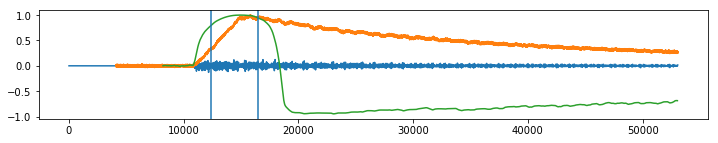

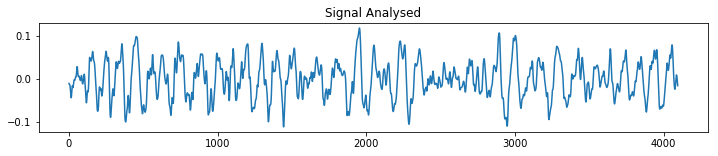

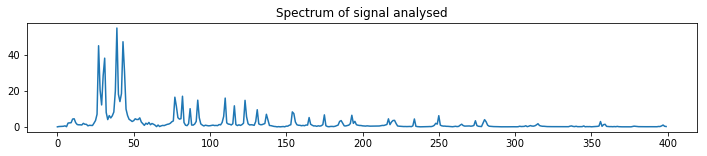

--results--
(62, 64, 68, 70)
[62, 68]
C4_60_61_67_x


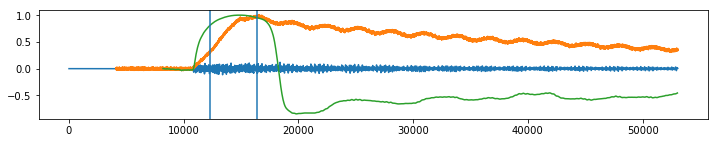

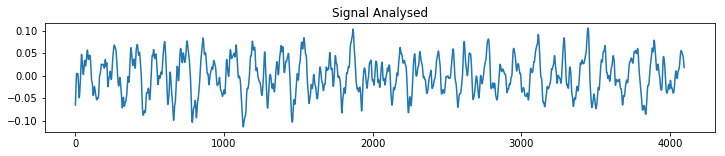

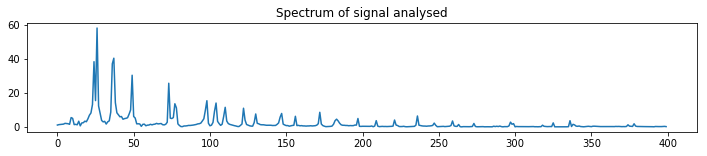

--results--
(60, 61, 67)
[61]
C4_61_62_67_69


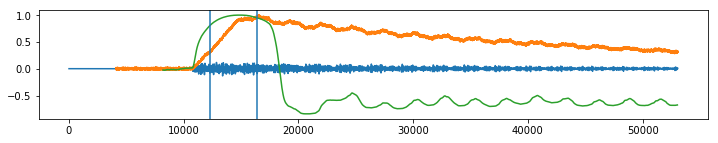

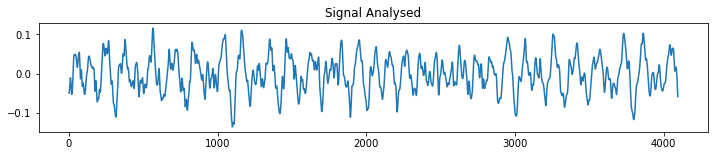

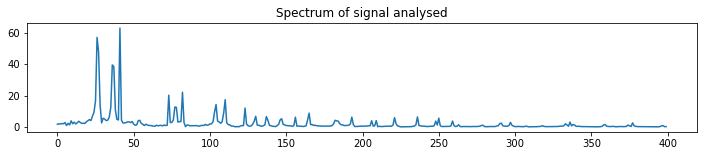

--results--
(61, 62, 67, 69)
[61, 67]
C4_64_65_69_71


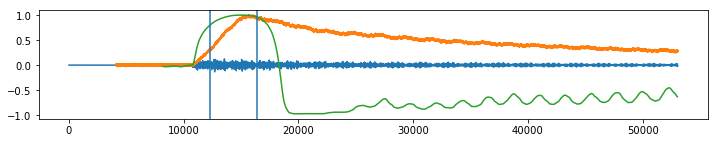

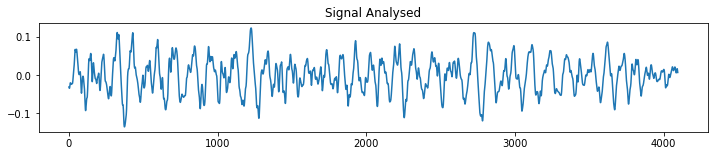

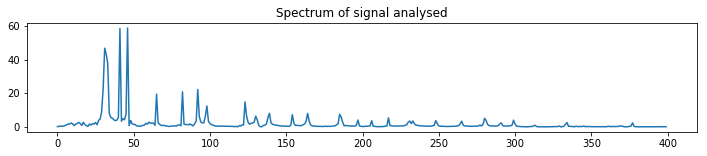

--results--
(64, 65, 69, 71)
[64, 69]
C4_63_67_69_x


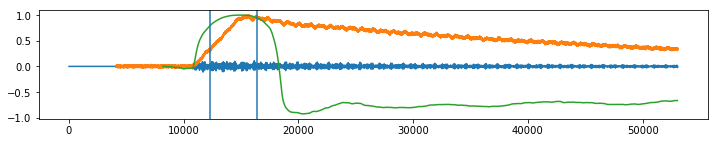

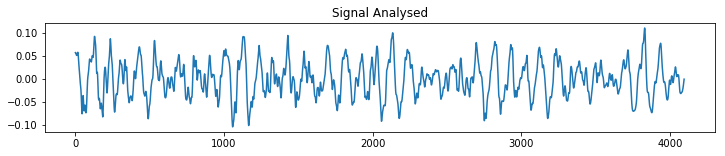

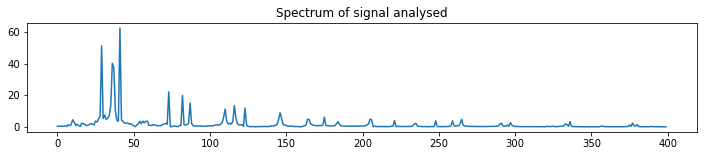

--results--
(63, 67, 69)
[63, 67, 69]
C4_60_61_x_x


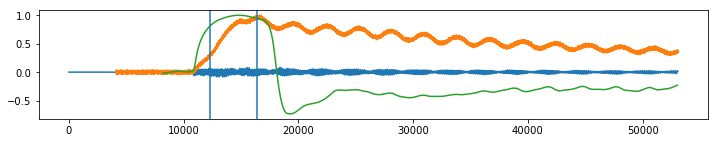

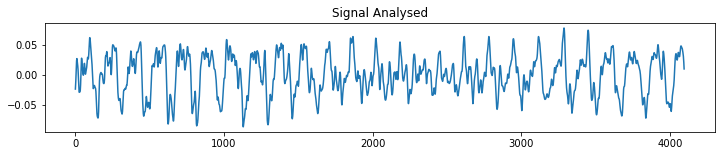

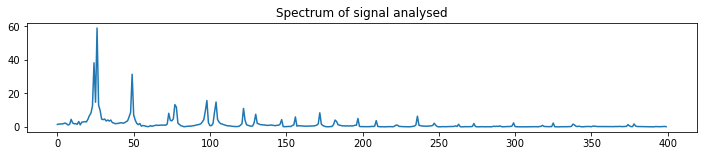

--results--
(60, 61)
[61]
C4_67_70_x_x


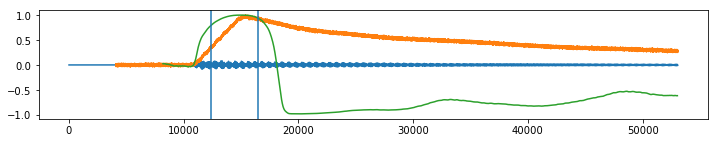

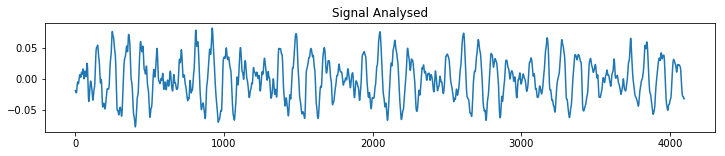

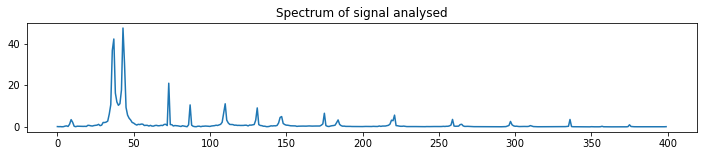

--results--
(67, 70)
[67, 70]
C4_60_64_67_71


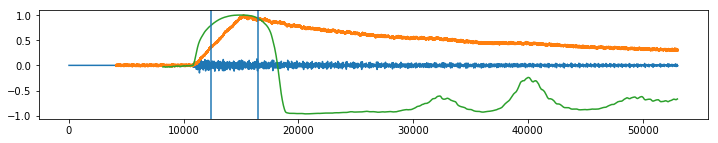

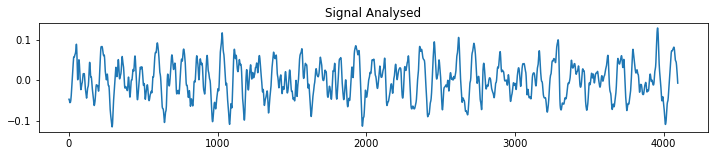

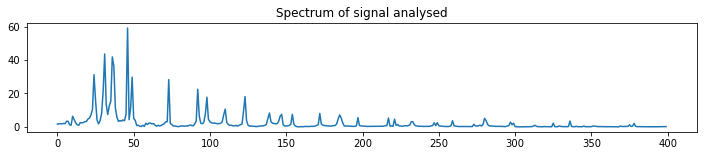

--results--
(60, 64, 67, 71)
[]
C4_60_67_70_71


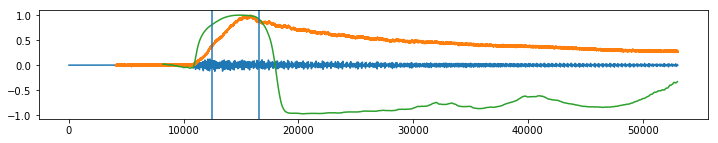

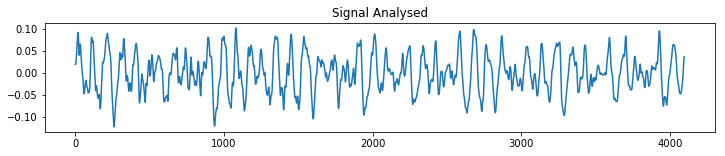

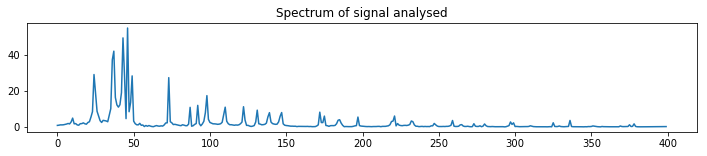

--results--
(60, 67, 70, 71)
[]
C4_66_67_68_69


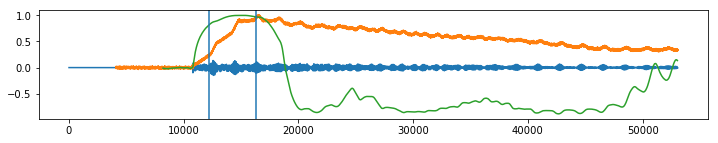

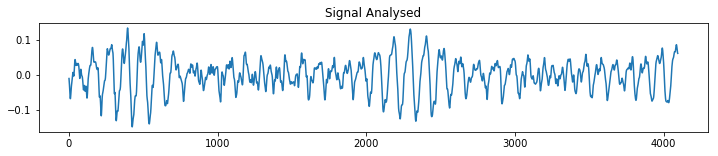

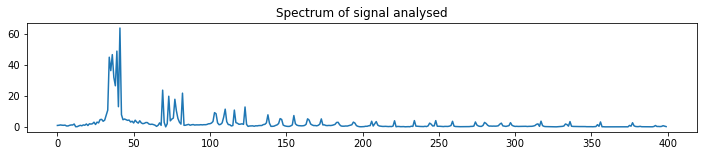

--results--
(66, 67, 68, 69)
[66, 68, 69]
C4_66_69_71_x


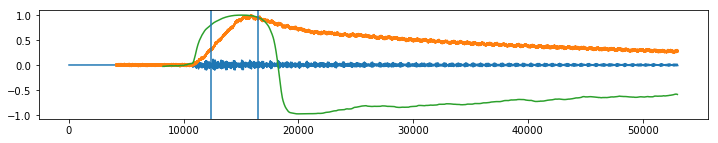

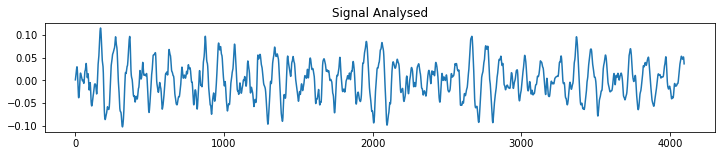

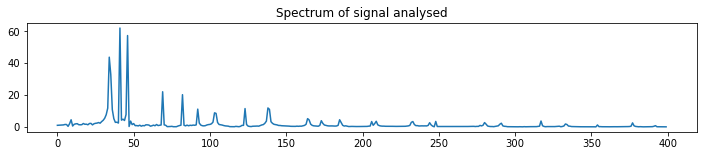

--results--
(66, 69, 71)
[66, 69]
C4_60_61_62_70


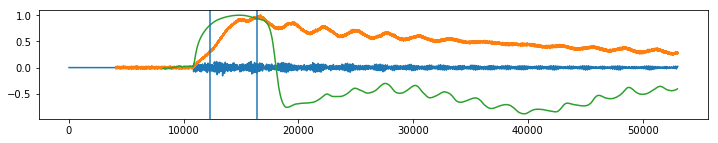

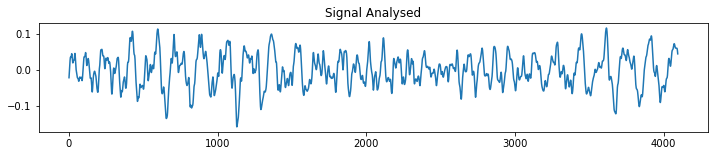

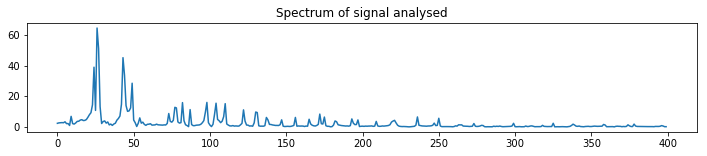

--results--
(60, 61, 62, 70)
[61]
C4_62_71_x_x


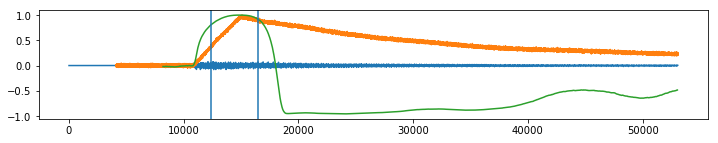

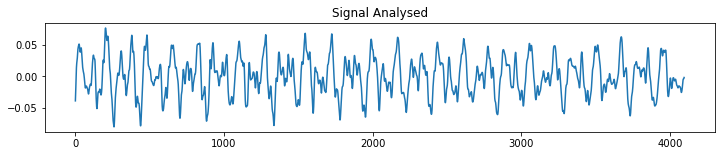

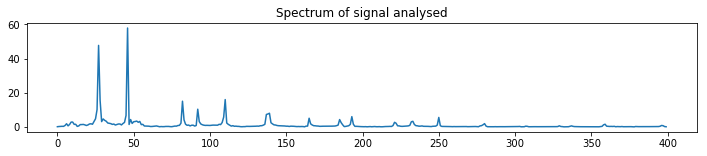

--results--
(62, 71)
[62, 71]
C4_61_67_68_x


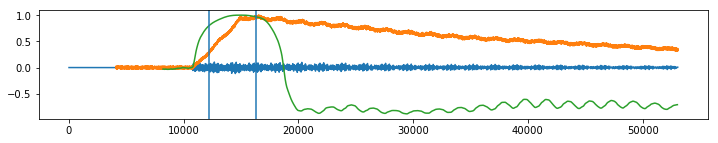

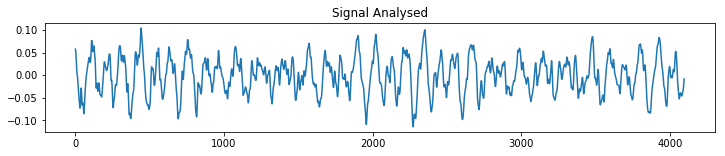

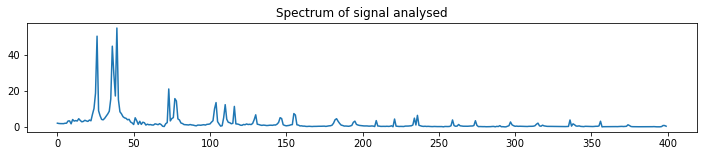

--results--
(61, 67, 68)
[61, 67, 68]
C4_61_63_69_x


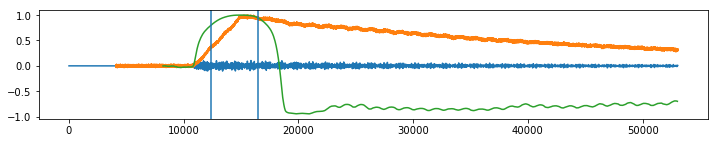

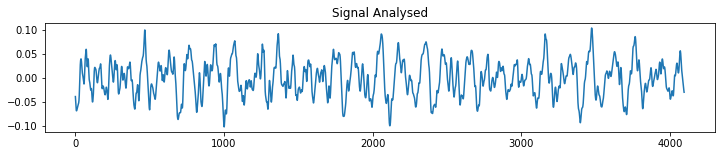

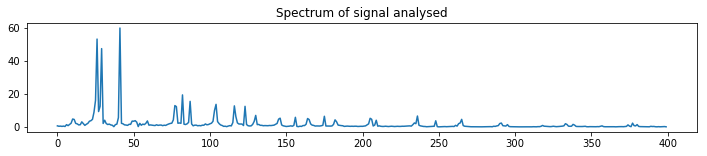

--results--
(61, 63, 69)
[61, 63, 69]
C4_62_63_64_65


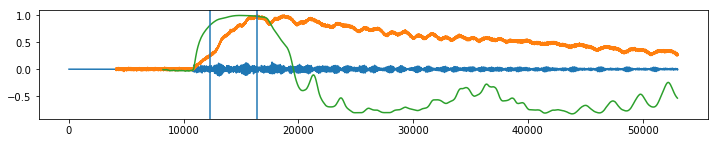

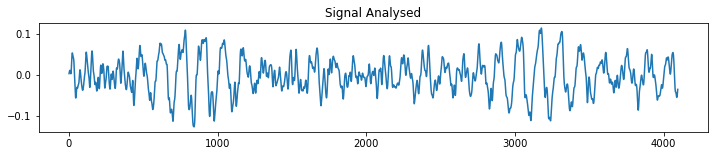

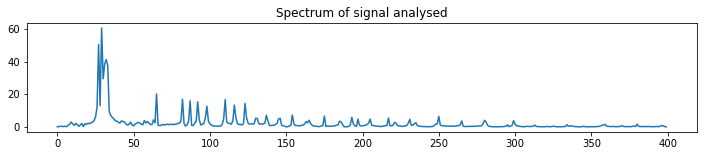

--results--
(62, 63, 64, 65)
[62, 63, 64]
C4_60_68_71_x


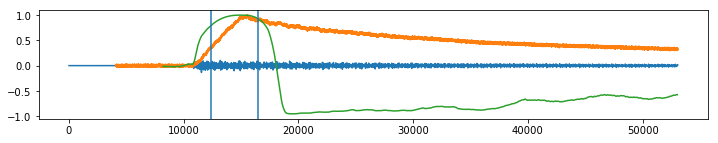

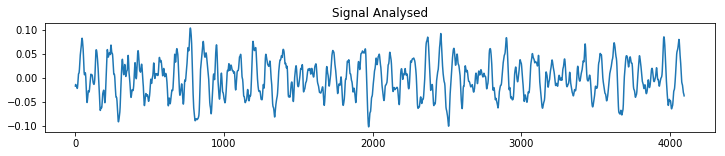

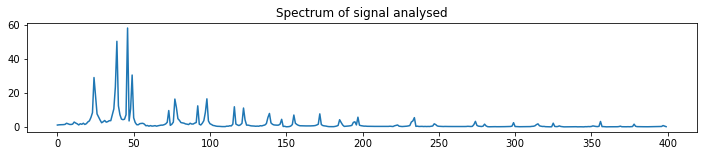

--results--
(60, 68, 71)
[60, 68, 71]
C4_61_62_66_71


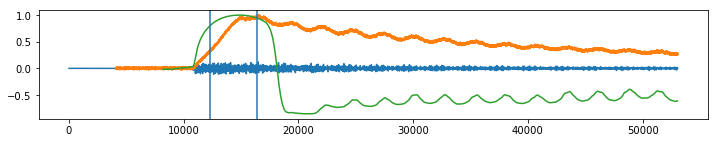

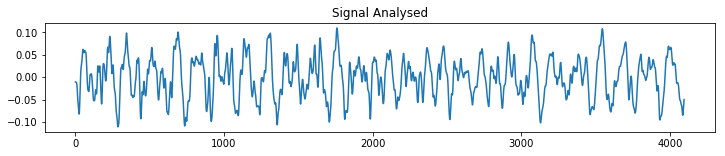

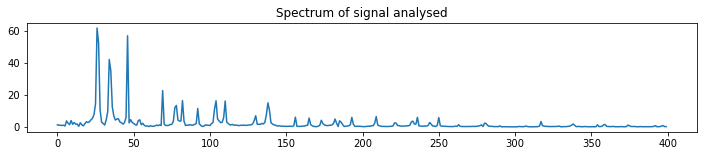

--results--
(61, 62, 66, 71)
[61, 66]
C4_60_62_69_71


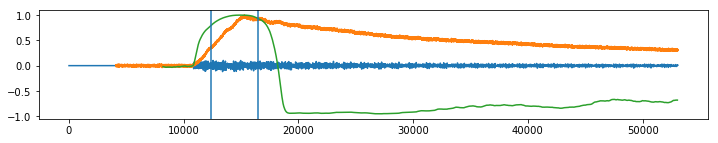

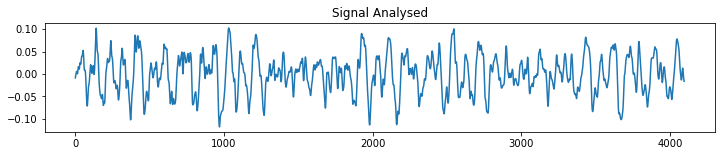

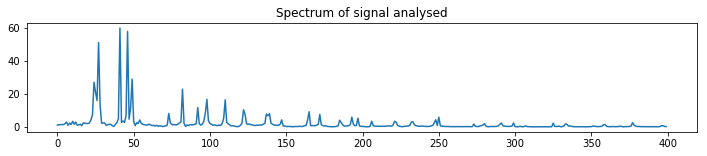

--results--
(60, 62, 69, 71)
[62]
C4_61_63_x_x


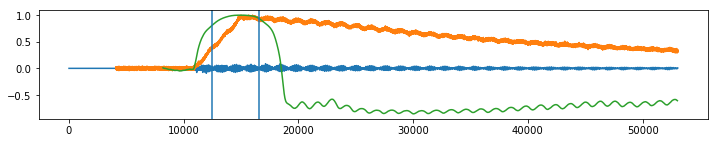

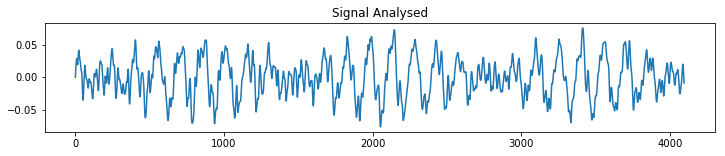

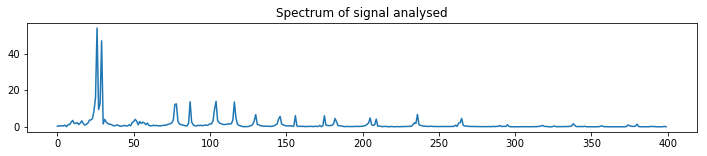

--results--
(61, 63)
[61, 63]
C4_63_66_71_x


KeyboardInterrupt: 

In [11]:
# can loop in other ways or random
comb_list = []
for scale in scales:
    for no_ in no_of_notes:
        
        pitch = range(12*(scale), 12*(scale+1))
        comb = [x for x in combinations(pitch, no_)]
        comb_list += comb
        track = range(no_)
        
for com in np.random.permutation(comb_list):
    generate_and_train(len(com),track,com)